<a href="https://colab.research.google.com/github/manishmcsa/S5-Assigment-Solution/blob/main/BatchNorm_Maxpooling_GAP_Dropout_Learning_rate_Image_Rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [146]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-3.0, 3.0), fill=(1,)),
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [147]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [148]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


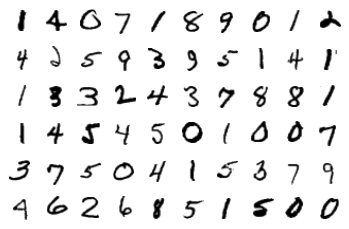

In [149]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [150]:
import torch.nn.functional as F
dropout_value=0.05
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        #input Block
        self.convblock1=nn.Sequential(
                                        nn.Conv2d(in_channels=1,out_channels=15,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(15),
                                        nn.ReLU(),
                                        nn.Dropout2d(dropout_value)
                                        ) # Input_size=28*28*1 kernel_size=3*3*10 Ouput_size=26*26*10
        self.convblock2=nn.Sequential(
                                        nn.Conv2d(in_channels=15,out_channels=15,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(15),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                        ) # Input_size=26*26*10 kernel_size=3*3*20 Ouput_size=24*24*20
        self.convblock3=nn.Sequential(
                                        nn.Conv2d(in_channels=15,out_channels=20,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(20),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                        ) # Input_size=24*24*20 kernel_size=3*3*20 Ouput_size=22*22*20
    
        self.pool1=nn.MaxPool2d(2,2) # Input_size=22*22*24 Ouput_size=11*11*20

        self.convblock4=nn.Sequential(
                                        nn.Conv2d(in_channels=20, out_channels=15, kernel_size=(1,1),padding=0,bias=False),
                                        nn.BatchNorm2d(15),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                        ) # Input_size=11*11*20 kernel_size=1*1*10 Ouput_size=11*11*10
        
        self.convblock5=nn.Sequential(
                                        nn.Conv2d(in_channels=15,out_channels=15,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(15),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                        ) # Input_size=11*11*10 kernel_size=3*3*20 Ouput_size=9*9*20

        self.convblock6=nn.Sequential(
                                        nn.Conv2d(in_channels=15,out_channels=15,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(15),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                      ) # Input_size=9*9*20 kernel_size=3*3*12 Ouput_size=7*7*12

        self.convblock7=nn.Sequential(
                                        nn.Conv2d(in_channels=15,out_channels=20,kernel_size=(1,1),padding=0,bias=False),
                                        nn.BatchNorm2d(20),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value)
                                      ) # Input_size=7*7*12 kernel_size=1*1*10 Ouput_size=7*7*10

        self.gap = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=7)
                                    ) # Input_size=7*7*10  Ouput_size=1*1*10
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # Input_size=1*1*10  Ouput_size=1*1*10

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x=self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)                  

In [151]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model= Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             135
       BatchNorm2d-2           [-1, 15, 26, 26]              30
              ReLU-3           [-1, 15, 26, 26]               0
         Dropout2d-4           [-1, 15, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           2,025
       BatchNorm2d-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           2,700
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

In [152]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [153]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1428593397140503 Batch_id=468 Accuracy=90.44: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.11810421943664551 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.06016552075743675 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.05825309082865715 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.07970084995031357 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.00797051377594471 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.06168098375201225 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.11378716677427292 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.02439364604651928 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.026243552565574646 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.021015143021941185 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.0024028196930885315 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.005542302504181862 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.017732340842485428 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.052494630217552185 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]



Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

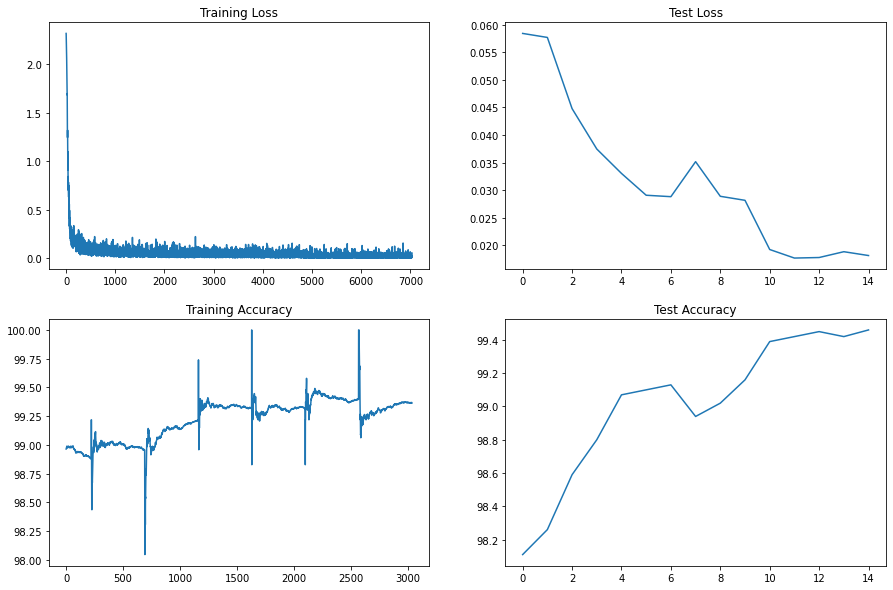

In [154]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")